# Descritores Globais: HOG, LBP e ELBP

## 1) Introdução
Nesta aula, focaremos em transformar a imagem inteira (ou grandes janelas dela) em um **vetor de características** numérico eficiente.

O objetivo é criar um **Feature Space** onde imagens de mesma classe (ex: "textura de tijolo" ou "pedestre") fiquem agrupadas próximas umas das outras, permitindo o uso de classificadores (SVM, KNN) ou busca por similaridade.

Veremos dois gigantes da visão clássica:
- **HOG:** Focado em **Forma** e **Contornos** (usando gradientes).
- **LBP:** Focado em **Textura** (usando padrões binários locais).

## 2) HOG (Histogram of Oriented Gradients)

Desenvolvido por Dalal & Triggs (2005) originalmente para detecção de pedestres. A intuição é que a aparência e a forma de objetos locais podem ser bem descritas pela distribuição de gradientes de intensidade.

### Pipeline Típico:
1.  **Pré-processamento:** Redimensionar para tamanho fixo (ex: 64x128).
2.  **Cálculo de Gradientes:** Usando filtros simples (ex: Sobel) para obter Magnitude e Direção em cada pixel.
3.  **Histograma de Orientações:** Divide a imagem em células (ex: 8x8 pixels). Cada pixel "vota" em um histograma de ângulos (ex: 9 bins de 0 a 180º), ponderado pela sua magnitude.
4.  **Normalização de Bloco:** As células são agrupadas em blocos maiores (ex: 2x2 células). O vetor de cada bloco é normalizado (L2-Hys ou L1) para mitigar efeitos de iluminação e contraste.
5.  **Vetor Final:** Concatenação de todos os vetores de blocos normalizados.

Tamanho do vetor HOG: (142884,)


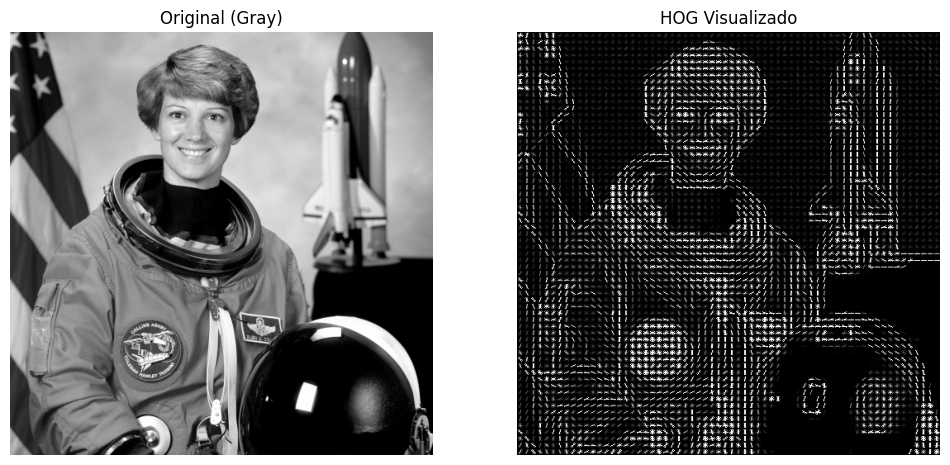

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import data
from skimage.feature import hog
from skimage import exposure

# 1. Setup e Imagem
img = data.astronaut()
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 2. Extraindo HOG
# pixels_per_cell=(8,8): Tamanho clássico da célula
# cells_per_block=(2,2): Bloco de normalização
# orientations=9: Número de bins no histograma de ângulo
fd, hog_image = hog(img_gray, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)

# Melhorando visualização (aumentando contraste da imagem do HOG)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

print(f"Tamanho do vetor HOG: {fd.shape}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(img_gray, cmap='gray'); ax1.set_title("Original (Gray)"); ax1.axis('off')
ax2.imshow(hog_image_rescaled, cmap='gray'); ax2.set_title("HOG Visualizado"); ax2.axis('off')
plt.show()

> **Nota:** O HOG "desenha" as bordas principais. Note como ele captura o contorno do capacete e o rosto, ignorando texturas suaves.

## 3) LBP (Local Binary Patterns)

O LBP (Ojala et al., 1996) descreve **textura** analisando a vizinhança de cada pixel. É extremamente eficiente computacionalmente e invariante a mudanças monotônicas de iluminação (brilho global).

### O Algoritmo (LBP Básico):
Para cada pixel central $c$ e seus vizinhos $p_i$:
1.  Compare vizinho com centro: Se $p_i \geq c$, bit=1, senão bit=0.
2.  Monte um número binário concatenando os bits (sentido horário).
3.  Converta para decimal (0-255).
4.  Calcule o histograma desses valores decimais para a imagem inteira (ou regiões).

In [3]:
# Exemplo "Mão na Massa": Cálculo em um patch 3x3
patch = np.array([
    [85,  70,  60],
    [90,  80,  75],
    [85,  95, 100]
])
center = patch[1, 1]  # 80

# Thresholding (Vizinho >= Centro)
binary_map = (patch >= center).astype(int)

# Leitura Horária (Norte -> Nordeste -> ... -> Noroeste)
# Posições (y,x): (0,1), (0,2), (1,2), (2,2), (2,1), (2,0), (1,0), (0,0)
neighbors_vals = [
    binary_map[0,1], binary_map[0,2], binary_map[1,2], binary_map[2,2],
    binary_map[2,1], binary_map[2,0], binary_map[1,0], binary_map[0,0]
]

# Convertendo bits para decimal
decimal_val = 0
for i, bit in enumerate(neighbors_vals):
    decimal_val += bit * (2**i)

print("Patch Original:\n", patch)
print("\nMapa Binário (>= 80):\n", binary_map)
print(f"\nBits: {neighbors_vals}")
print(f"Valor LBP Decimal: {decimal_val}")

Patch Original:
 [[ 85  70  60]
 [ 90  80  75]
 [ 85  95 100]]

Mapa Binário (>= 80):
 [[1 0 0]
 [1 1 0]
 [1 1 1]]

Bits: [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
Valor LBP Decimal: 248


### Aplicando LBP na imagem

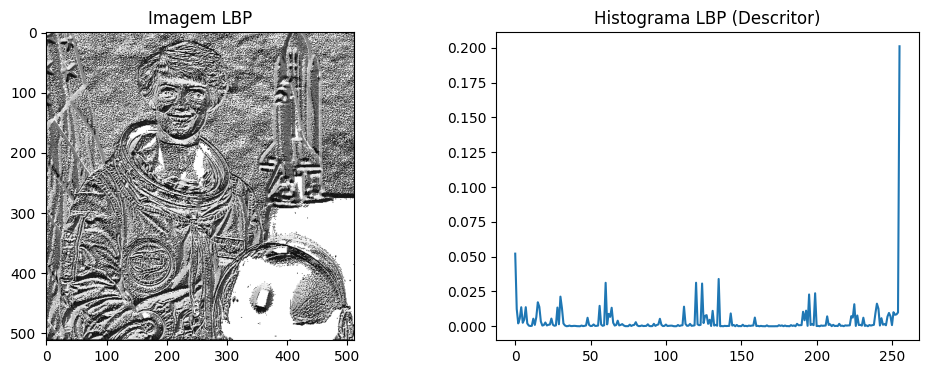

In [4]:
from skimage.feature import local_binary_pattern

# Parâmetros LBP
radius = 1
n_points = 8 * radius  # Vizinhos
METHOD = 'default' # LBP original

lbp_img = local_binary_pattern(img_gray, n_points, radius, METHOD)

# Histograma do LBP (Descritor Global de Textura)
# n_bins = 2**n_points (256 para 8 vizinhos)
hist_lbp, _ = np.histogram(lbp_img.ravel(), bins=256, range=(0, 256))

# Normalizar (L1)
hist_lbp = hist_lbp.astype("float")
hist_lbp /= (hist_lbp.sum() + 1e-6)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.imshow(lbp_img, cmap='gray'); ax1.set_title("Imagem LBP")
ax2.plot(hist_lbp); ax2.set_title("Histograma LBP (Descritor)")
plt.show()

## 4) Extensão: ELBP (Entropy LBP)
*(Tópico Extra)*

O ELBP combina a informação de padrões locais (LBP) com a informação de **complexidade** local (Entropia). Em regiões lisas, o LBP pode ser ruidoso ou pouco informativo; a entropia ajuda a ponderar isso.

Uma forma simples de implementar é concatenar o histograma de LBP com o histograma de entropia local.

In [5]:
from skimage.filters.rank import entropy
from skimage.morphology import disk

def extract_elbp(image):
    # 1. LBP Hist
    lbp = local_binary_pattern(image, 8, 1, 'default')
    h_lbp, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
    h_lbp = h_lbp.astype('float') / (h_lbp.sum() + 1e-6)
    
    # 2. Entropy Hist (janela disco raio 3)
    # Entropia calcula a "desordem" local
    ent = entropy(image, disk(3))
    h_ent, _ = np.histogram(ent.ravel(), bins=10, range=(0, 5))
    h_ent = h_ent.astype('float') / (h_ent.sum() + 1e-6)
    
    # Concatena
    return np.concatenate([h_lbp, h_ent])

feat_elbp = extract_elbp(img_gray)
print(f"Vetor ELBP Combinado: {feat_elbp.shape} (256 LBP + 10 Entropy)")

Vetor ELBP Combinado: (266,) (256 LBP + 10 Entropy)


## 5) Demo: Ranking de Similaridade (HOG vs LBP)

Vamos comparar o que cada descritor "enxerga" melhor.

Query: cat_noise


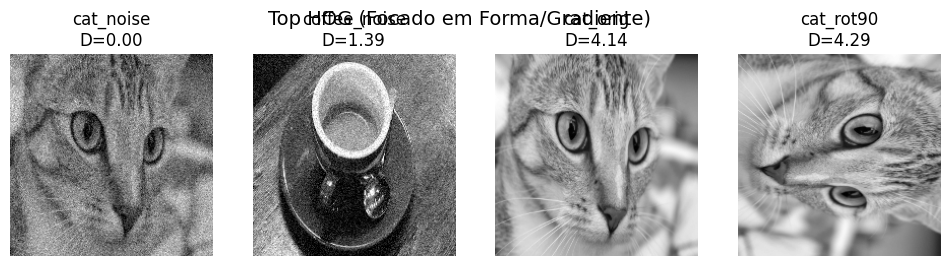

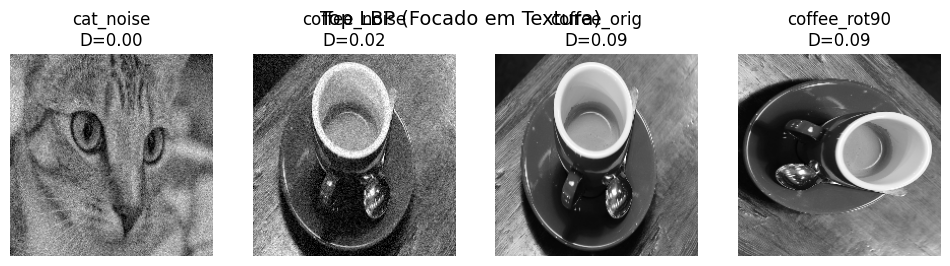

In [6]:
# Dataset: Gato (Chelsea), Café (Xícara) e variações
base = {
    'cat': cv2.cvtColor(data.chelsea(), cv2.COLOR_RGB2GRAY),
    'coffee': cv2.cvtColor(data.coffee(), cv2.COLOR_RGB2GRAY)
}

imgs_db = []
labels_db = []
hog_db = []
lbp_db = []

def add(img, label):
    # Extract HOG
    h = hog(img, orientations=9, pixels_per_cell=(16,16), cells_per_block=(1,1))
    # Extract LBP Hist
    lbp = local_binary_pattern(img, 8, 1, 'default')
    l_hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
    l_hist = l_hist.astype('float') / (l_hist.sum() + 1e-6)
    
    imgs_db.append(img)
    labels_db.append(label)
    hog_db.append(h)
    lbp_db.append(l_hist)

for name, im in base.items():
    # Resize para garantir mesmo tamanho p/ HOG
    im = cv2.resize(im, (200, 200))
    
    add(im, f"{name}_orig")
    add(cv2.rotate(im, cv2.ROTATE_90_CLOCKWISE), f"{name}_rot90")
    add(cv2.GaussianBlur(im, (5,5), 0), f"{name}_blur")
    
    noise = im + np.random.normal(0, 20, im.shape)
    add(np.clip(noise, 0, 255).astype(np.uint8), f"{name}_noise")

# Query: Gato com ruído
q_idx = 3 # cat_noise
print(f"Query: {labels_db[q_idx]}")

def get_top_k(features_db, query_feat, k=4):
    dists = []
    for i, f in enumerate(features_db):
        # L2 Distance
        d = np.linalg.norm(query_feat - f)
        dists.append((d, i))
    dists.sort(key=lambda x: x[0])
    return dists[:k]

top_hog = get_top_k(hog_db, hog_db[q_idx])
top_lbp = get_top_k(lbp_db, lbp_db[q_idx])

def plot_res(top_list, title):
    fig, ax = plt.subplots(1, len(top_list), figsize=(12,3))
    fig.suptitle(title, fontsize=14)
    for a, (d, i) in zip(ax, top_list):
        a.imshow(imgs_db[i], cmap='gray')
        a.set_title(f"{labels_db[i]}\nD={d:.2f}")
        a.axis('off')
    plt.show()

plot_res(top_hog, "Top HOG (Focado em Forma/Gradiente)")
plot_res(top_lbp, "Top LBP (Focado em Textura)")

## 6) Conclusão
- **HOG** é excelente para objetos rígidos e contornos (reparesenta a forma do gato).
- **LBP** captura micro-texturas. É mais robusto a rotação se usarmos variações avançadas (como "Uniform LBP" ou "Rotation Invariant LBP"), mas o LBP básico pode ser sensível a rotação pixel-a-pixel.

No pipeline real, muitas vezes usamos **HOG + LBP** concatenados para ter o melhor dos dois mundos.